In [78]:
from PIL import Image
import numpy as np
import matplotlib.image as img
import os
import time
import glob
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.fftpack import dct ,idct
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap, TSNE
from scipy.spatial.distance import cdist
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd



In [79]:
#This data set is a reduced version of the MNIST dataset with 10000 training examples(1000 examples for each digit)
#and 2000 test examples (200 test examples for each digit)

#prepare train and test datasets for extracting features and classifing
train_folder='drive/MyDrive/Reduced MNIST Data/Reduced Training data';
test_folder='drive/MyDrive/Reduced MNIST Data/Reduced Testing data';
train_images_names=[];
test_images_names=[];

In [80]:
for i in range(10):
  # two lists of all training,testing images names
  train_images_names.append(glob.glob('{}/{}/*.jpg'.format(train_folder,i)))
  test_images_names.append(glob.glob('{}/{}/*.jpg'.format(test_folder,i)))

# Expanding sublists into one list
train_images_names = [item for sublist in train_images_names for item in sublist];
test_images_names = [item for sublist in test_images_names for item in sublist];



**TRAIN AND TEST DATASETS**

In [81]:
#training , test data from lists
test_dataset = np.array([np.array(Image.open(fname)) for fname in test_images_names])
train_dataset = np.array([np.array(Image.open(fname)) for fname in train_images_names])


# Adding a label coressponding each training and testing example
train_label=np.array([list(map(int, re.findall(r'\b\d\b', fname)))[0]  for fname in train_images_names])
test_label=np.array([list(map(int, re.findall(r'\b\d\b', fname)))[0]  for fname in test_images_names])

# Shuffling the training ,test data while keeping the corresponding label
# Normalizing data for faster convergence
train_dataset,train_label = shuffle(train_dataset/255, train_label)
test_dataset,test_label= shuffle(test_dataset/255, test_label)



In [88]:
print("training data shape is ",train_dataset.shape)
print("Test data shape is ",test_dataset.shape)
print("The min value of a pixel after normalization",train_dataset.min())
print("The max value of a pixel after normalization",train_dataset.max())


training data shape is  (10010, 28, 28)
Test data shape is  (2000, 28, 28)
The min value of a pixel after normalization 0.0
The max value of a pixel after normalization 1.0


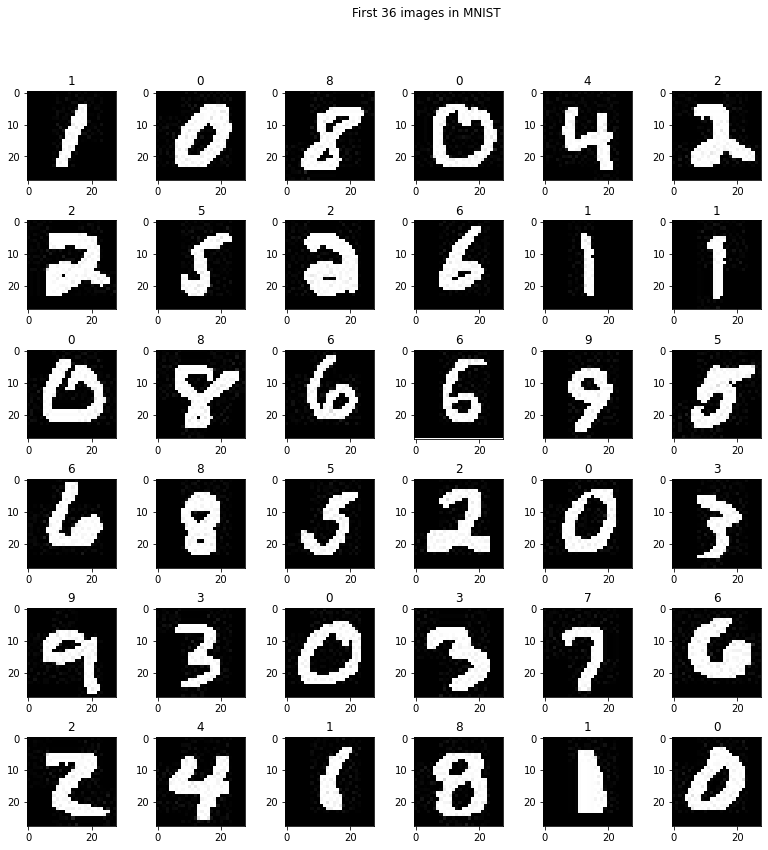

In [89]:
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(train_dataset[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(train_label[x + y * 6])


In [83]:

# Functions used to extract DCT features

# 2-D DCT feature extractor
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

#zigzag of DCT taking only first 200 elements
def zigzag(a):

   x=np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])

   return x[0:200]

# 2-D inverse DCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def get_dct_features(a):
  ''' Computes DCT features for all examples of training data
  :a: training data
  :DCT_ordered: DCT features for a single image in zigzag order
  :DCT_features: DCT feature of all training examples in zigzag order'''
  DCT_features=np.zeros((a.shape[0],200))

  for i in range(a.shape[0]):
    DCT_ordered=zigzag(dct2(a[i]))
    DCT_features[i] = DCT_ordered

  return DCT_features.reshape((a.shape[0],-1))



In [84]:
DCT_features_train=get_dct_features(train_dataset)
print("The DCT features for training are now of size {} using DCT coefficients ".format(DCT_features_train.shape))
DCT_features_test=get_dct_features(test_dataset)
print("The DCT features for testing are now of size {} using DCT coefficients ".format(DCT_features_test.shape))
f5 = open("drive/MyDrive/dct_train.txt", 'w')
f6 = open("drive/MyDrive/dct_test.txt", 'w')
f5.write("[")
for i in range(DCT_features_train.shape[0]):
  f5.write("[")
  for k in range(DCT_features_train.shape[1]):
    f5.write(str(DCT_features_train[i][k]))
    f5.write(" ")
  f5.write("]\n")
f5.write("]")

f6.write("[")
for i in range(DCT_features_test.shape[0]):
  f6.write("[")
  for k in range(DCT_features_test.shape[1]):
    f6.write(str(DCT_features_test[i][k]))
    f6.write(" ")
  f6.write("]\n")
f6.write("]")


The DCT features for training are now of size (10010, 200) using DCT coefficients 
The DCT features for testing are now of size (2000, 200) using DCT coefficients 


1

In [85]:

  # PCA such the 90% of the variance is retained
pca = PCA(0.90)
pca.fit(train_dataset.reshape((train_dataset.shape[0],784)))
train_pca = pca.transform(train_dataset.reshape((train_dataset.shape[0],784)))
test_pca = pca.transform(test_dataset.reshape((test_dataset.shape[0],784)))

print("The components number for 90% variance is ",pca.n_components_)
print("The PCA features using all 784 dims for training are now of size {}".format(train_pca.shape))
print("The PCA features using all 784 dims for testing are now of size {}".format(test_pca.shape))

f = open("drive/MyDrive/pca_train.txt", 'w')
f2 = open("drive/MyDrive/pca_test.txt", 'w')
f.write("[")
for i in range(train_pca.shape[0]):
  f.write("[")
  for k in range(train_pca.shape[1]):
    f.write(str(train_pca[i][k]))
    f.write(" ")
  f.write("]\n")
f.write("]")

f2.write("[")
for i in range(test_pca.shape[0]):
  f2.write("[")
  for k in range(test_pca.shape[1]):
    f2.write(str(test_pca[i][k]))
    f2.write(" ")
  f2.write("]\n")
f2.write("]")



The components number for 90% variance is  167
The PCA features using all 784 dims for training are now of size (10010, 167)
The PCA features using all 784 dims for testing are now of size (2000, 167)


1

In [86]:
lda = LDA(n_components=8)#Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.
lda_train = lda.fit_transform(train_dataset.reshape((train_dataset.shape[0],784)), train_label)
lda_test = lda.transform(test_dataset.reshape((test_dataset.shape[0],784)))

print("The LDA features for training are now of size {}".format(lda_train.shape))
print("The LDA features for testing are now of size {}".format(lda_test.shape))


f3 = open("drive/MyDrive/lda_train.txt", 'w')
f4 = open("drive/MyDrive/lda_test.txt", 'w')
f3.write("[")
for i in range(lda_train.shape[0]):
  f3.write("[")
  for k in range(lda_train.shape[1]):
    f3.write(str(lda_train[i][k]))
    f3.write(" ")
  f3.write("]\n")
f3.write("]")

f4.write("[")
for i in range(lda_test.shape[0]):
  f4.write("[")
  for k in range(lda_test.shape[1]):
    f4.write(str(lda_test[i][k]))
    f4.write(" ")
  f4.write("]\n")
f4.write("]")

The LDA features for training are now of size (10010, 8)
The LDA features for testing are now of size (2000, 8)


1

In [90]:
def pred_labeled(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return y_voted_labels